In [1]:
import warnings
warnings.filterwarnings("ignore")

import scipy
from scipy.sparse import csc_matrix, linalg

from math import factorial, floor
import numpy as np

import matplotlib.pyplot as plt
font = {'size'   : 14}
plt.rc('font', **font)

In [2]:
def Vfunction(i, N):
    sum1 = 0.
    kmin = int(floor((i + 1.) / 2.))
    kmax = min(i, N)
    for k in range(kmin, kmax+1):
        sum1 += (1.*(k**N) * factorial(2 * k) / (factorial(N - k) * factorial(k) * factorial(k - 1) * factorial(i - k) * factorial(2 * k - i)))
    return ((-1.)**(N + i)) * sum1

In [3]:
def solve(matrixR,vectorF):
    return linalg.spsolve(csc_matrix(matrixR, dtype=float), csc_matrix(vectorF, dtype=float)) # only for nCells <= 100 x 100

    # Iterative solvers###################################
    # Minimal residual iterative method (krylov) # can reach to nCells = 400 x 400 or more
    
    '''A = csc_matrix(matrixR, dtype=float)
    A = A + A.T
    vectorU, exitCode = scipy.sparse.linalg.minres(A, vectorF,tol=1e-100, maxiter=20000, show=False)
    print(np.allclose(A.dot(vectorF), vectorU))
    return vectorU'''

In [4]:
def rigidity(nx, ny, s, x,y, cxx,cyy,cf, phi):
    nCell = nx*ny
    M = np.zeros((nCell,nCell))
    
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            iCell = i*ny + j
            iW = (i-1)*ny + j
            iE = (i+1)*ny + j
            iS = iCell - 1
            iN = iCell + 1

            l1 = (y[i][j+1]-y[i][j-1])/2.
            l2 = (x[i+1][j]-x[i-1][j])/2.

            c1xi  = (cxx[i][j] + cxx[i-1][j]) /2. /l2 /(x[i][j] - x[i-1][j])
            c2eta =-(cyy[i][j+1] + cyy[i][j]) /2. /l1 /(y[i][j+1] - y[i][j])
            c3xi  =-(cxx[i+1][j] + cxx[i][j]) /2. /l2 /(x[i+1][j] - x[i][j])
            c4eta = (cyy[i][j] + cyy[i][j-1]) /2. /l1 /(y[i][j] - y[i][j-1])

            M[iCell][iCell] = s + c1xi - c2eta - c3xi + c4eta

            M[iCell][iW] = -c1xi         
            M[iCell][iN] = c2eta
            M[iCell][iE] = c3xi
            M[iCell][iS] = -c4eta

    
    # Pressure boundary condition on top and bottom sides  
    for i in range(0,nx):
        for j in range(0,nCell):
            M[(i+1)*ny-1][j] = 0. 
            M[i*ny][j] = 0.

        M[(i+1)*ny-1][(i+1)*ny-1] = 1. 
        M[i*ny][i*ny] = 1. 

    # Flow rate boundary condition on left and right sides    
    for i in range(0,nx):
        for j in range(0,nCell):
            M[i][j] = 0.
            M[nCell-1-i][j] = 0.
            
        M[i][i] = 1.
        M[i][i+ny] = -1.

        M[nCell-1-i][nCell-1-i] = 1.
        M[nCell-1-i][nCell-1-i-ny] = -1.
    return M

def addFracture(M, fracture):
    # Fracture
    for idx in range(1,len(fracture)-1):
        # Location of a cell along the fracture
        i,j = fracture[idx]
        iCell = i*ny + j
        
        # Initialize the line of the rigidity matrix at iCell
        for k in range(0,nCell):
            M[iCell][k] = 0. 
            
        iW = (i-1)*ny + j
        iE = (i+1)*ny + j
        iS = iCell - 1
        iN = iCell + 1

        l1 = (y[i][j+1]-y[i][j-1])/2.
        l2 = (x[i+1][j]-x[i-1][j])/2.
        
        cfW  = phi*(cxx[i][j] + cxx[i-1][j]) /2. /(x[i][j] - x[i-1][j])

        cfE  = -phi*(cxx[i+1][j] + cxx[i][j]) /2. /(x[i+1][j] - x[i][j])

        M[iCell][iCell] = s + 2.*cf/l1**2. + cfW - cfE

        M[iCell][iN] = -cf/l1**2.
        M[iCell][iS] = -cf/l1**2.
        M[iCell][iW] = -cfW         
        M[iCell][iE] = cfE

    # Fracture tip on the bottom side
    # The cell corresponding to the fracture tip
    i,j = fracture[0]
    iCell = i*ny + j
    
    # Initialize the line of the rigidity matrix at iCell
    for k in range(0,nCell):
        M[iCell][k] = 0. 

    iW = (i-1)*ny + j
    iE = (i+1)*ny + j
    iS = iCell - 1
    iN = iCell + 1

    l1 = (y[i][j+1]-y[i][j-1])/2.
    l2 = (x[i+1][j]-x[i-1][j])/2.

    cfW  = phi*(cxx[i][j] + cxx[i-1][j]) /2. /(x[i][j] - x[i-1][j])
    cfE  = -phi*(cxx[i+1][j] + cxx[i][j]) /2. /(x[i+1][j] - x[i][j])

    M[iCell][iCell] = s + cf/l1**2. + cfW - cfE
    M[iCell][iN] = -cf/l1**2.
    M[iCell][iW] = -cfW         
    M[iCell][iE] = cfE

    # Fracture tip on the top side
    # The cell corresponding to the fracture tip
    i,j = fracture[-1]
    iCell = i*ny + j
    
    # Initialize the line of the rigidity matrix at iCell
    for k in range(0,nCell):
        M[iCell][k] = 0. 

    iW = (i-1)*ny + j
    iE = (i+1)*ny + j
    iS = iCell - 1
    iN = iCell + 1

    l1 = (y[i][j+1]-y[i][j-1])/2.
    l2 = (x[i+1][j]-x[i-1][j])/2.

    cfW  = phi*(cxx[i][j] + cxx[i-1][j]) /2. /(x[i][j] - x[i-1][j])
    cfE  = -phi*(cxx[i+1][j] + cxx[i][j]) /2. /(x[i+1][j] - x[i][j])

    M[iCell][iCell] = s + cf/l1**2. + cfW - cfE
    M[iCell][iS] = -cf/l1**2.
    M[iCell][iW] = -cfW         
    M[iCell][iE] = cfE
    
    return M

In [5]:
def generate_fracture(x,y,nx,ny, tip1, tip2, withoutExtension = True, verbose=0):
    inclined_fracture = []
    for i in range(nx-1):
        for j in range(ny-1):
            dx = x[i+1,j] - x[i,j]
            dy = y[i,j+1] - y[i,j]
            xCell = x[i,j]
            yCell = y[i,j]

            cell_in_fracture = line_passes_through_cell(tip1, tip2, xCell, yCell, dx, dy, withoutExtension, verbose)
            if cell_in_fracture:
                inclined_fracture.append([i,j])  
    return inclined_fracture

def line_passes_through_cell(point1, point2, xCell, yCell, dx, dy, withoutExtension, verbose):
    # Tolerance
    tol_x = 0.1*dx
    tol_y = 0.1*dy
    
    # First, check if either point is inside the cell
    if (xCell - dx/2 < point1[0] < xCell + dx/2 and
        yCell - dy/2 < point1[1] < yCell + dy/2) or \
       (xCell - dx/2 < point2[0] < xCell + dx/2 and
        yCell - dy/2 < point2[1] < yCell + dy/2):
        if verbose == 1:
            print(f'Fracture tip is inside the cell {xCell, yCell}')
        return True

    # If neither point is inside the cell, check if the line intersects the cell
    x1, y1 = point1
    x2, y2 = point2

    # Check if line is vertical
    if x1 == x2:
        if x1 >= xCell - dx/2 + tol_x and x1 <= xCell + dx/2 - tol_x:
            if withoutExtension: # If extention of the fracture line is not allowed, it is needed to verify if the cell center is between the tips
                if min(y1,y2) + tol_y <= yCell <= max(y1,y2) - tol_y:
                    if verbose == 1:
                        print(f'Vertical fracture passes through the cell {xCell, yCell}')
                    return True
                else:
                    if verbose == 1:
                        print(f'Vertical fracture does not pass through the cell {xCell, yCell}, its extension passes through the cell')
                    return False
            else: # If extention of the fracture line is allowed, it is not needed to verify if the cell center is between the tips
                return True
        else:
            if verbose == 1:
                print(f'Vertical fracture does not pass through the cell {xCell, yCell}')
            return False
    
    # Check if line is horizontal
    if y1 == y2:
        if y1 >= yCell - dy/2 + tol_y and y1 <= yCell + dy/2 - tol_y:
            if withoutExtension: # If extention of the fracture line is not allowed, it is needed to verify if the cell center is between the tips
                if min(x1,x2) + tol_x <= xCell <= max(x1,x2) - tol_x:
                    if verbose == 1:
                        print(f'Horizontal fracture passes through the cell {xCell, yCell}')
                    return True
                else:
                    if verbose == 1:
                        print(f'Horizontal fracture does not pass through the cell {xCell, yCell}, its extension passes through the cell')
                    return False
            else: # If extention of the fracture line is allowed, it is not needed to verify if the cell center is between the tips
                return True
        else:
            if verbose == 1:
                print(f'Horizontal fracture does not pass through the cell {xCell, yCell}')
            return False

    # Calculate slope and y-intercept of line
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m*x1

    # Calculate x-coordinates of intersection points with upper and lower cell boundaries
    x_lower = (yCell - dy/2 - b) / m
    x_upper = (yCell + dy/2 - b) / m

    # Check if intersection points bound a point in the cell
    if min(x_lower, x_upper) < xCell - dx/2 + tol_x < max(x_lower, x_upper) or \
       min(x_lower, x_upper) < xCell + dx/2 - tol_x < max(x_lower, x_upper):
        if min(x1,x2) + tol_x <= xCell <= max(x1,x2) - tol_x:
            if withoutExtension: # If extention of the fracture line is not allowed, it is needed to verify if the cell center is between the tips
                if verbose == 1:
                    print(f'Inclined fracture pass through the cell {xCell, yCell}')
                    print(f'x_lower={x_lower}, x_upper={x_upper}')
                return True
            else: # If extention of the fracture line is allowed, it is not needed to verify if the cell center is between the tips
                return True
        else:
            if verbose == 1:
                print(f'Inclined fracture point toward the cell {xCell, yCell} but does not pass through it')
                print(f'x_lower={x_lower}, x_upper={x_upper}')
            return False
    else:
        if verbose == 1:
            print(f'Inclined fracture does not pass through the cell {xCell, yCell}')
            print(f'x_lower={x_lower}, x_upper={x_upper}')
        return False


In [6]:
# Geometry
Lx = 10.
Ly = 10.
nx = 101 #issue while defining nx<ny
ny = 101
x, y = np.mgrid[-Lx/2.:Lx/2.:nx*1j, -Ly/2.:Ly/2.:ny*1j]

In [7]:
# Apply unit pressure gradient
pTop = Ly/2
pBot = -Ly/2

t = 1e7    # Time, must be large enough to fit with steady-state results

muf = 1e-3 # Fluid dynamic viscosity
c_fluid = 5e-10 # Fluid compressibility
permeability = 1e-18 # Intrinsic permeability
kappa = permeability/muf 
phi = 0.1 # Porosity

# Biot's modulus
M = 1./(phi*c_fluid) # Simple approximation for pure fluid flow problem without mechanical deformation

# Diffusion coefficient
c = kappa * M

#e = 1e-5
#cf = e**3./12./muf/c_fluid  
ell = 1.0 # Fracture half length

lambda_ratio = 0.5
cf = lambda_ratio * 2.0*np.pi * permeability * ell/muf/c_fluid  

# Diffusion matrix
cxx = np.r_[ c*np.ones( ( int(nx/2.), ny ) ), c*np.ones( ( nx-int(nx/2.), ny ) ) ]
cyy = cxx

# Initialize the right-side vector
nCell = nx * ny
f = np.zeros(nCell)

# Update the right-side vector with pressure boundaries condition 
for i in range(0,nx):
    f[(i+1)*ny-1] = pTop
    f[i*ny] = pBot
  
f = f.reshape(len(f),1)

# Define a fracture
tip1 = [0,-1]
tip2 = [0,1]
fracture = generate_fracture(x,y,nx,ny, tip1, tip2)
            
# Solving the linear equation system by the Laplace-FVM method
N = 2
sum_p = np.zeros(nCell)

for j in range(1, 2*N+1):
    s = j * np.log(2.) / t
    M = rigidity(nx, ny, s,x,y,cxx,cyy,cf,phi)
    M = addFracture(M, fracture)
    
    p = solve(M,f/s)
    sum_p += Vfunction(j,N) * p

p = sum_p * np.log(2.) / t
p = p.reshape(nx,ny)

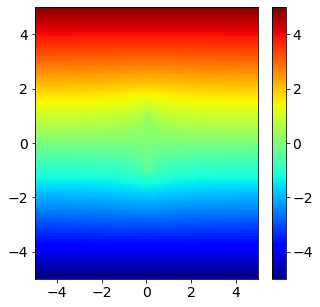

In [8]:
plt.figure(figsize=(Lx/2,Ly/2))
plt.pcolor(x, y, p, cmap='jet', vmin=-5, vmax=5)
#plt.xlim(-1,2)
#plt.ylim(-1,1)
plt.colorbar()
plt.show()

In [9]:
# For void crack, lambda_ratio=infty
def analytic2D(ell,x,y):
    return np.sign(y)*np.sqrt( np.sqrt( (ell**2 + x**2 - y**2)**2 + 4*(x**2)*(y**2) ) - (ell**2 + x**2 - y**2) )  / np.sqrt(2)

#plt.pcolor(x, y, analytic2D(ell,x,y), cmap='jet', vmin=-5, vmax=5)
#plt.colorbar()
#plt.show()

In [10]:
import pandas as pd

# Read data from text file into a pandas DataFrame
df = pd.read_csv('/kaggle/input/poiseuillecrackpressure/pouya2010pressureAroundPoiseuilleCrack_fig5_lambda05.txt', delimiter='\t')
# Print the first 5 rows of the DataFrame to check if it was read correctly
print(df.head())

          X         Y
0  0.000000  0.007126
1  0.187500  0.078385
2  0.337500  0.135392
3  0.487500  0.192399
4  0.646875  0.249406


In [11]:
# Extract data along fracture line
# fracture_extention = generate_fracture(x,y,nx,ny, tip1, tip2, withoutExtension = False, verbose=0):


# Extract a long the vertical middle line
p_TFVM = []
y_TFVM = []

for i in range(0, ny):
    p_TFVM.append(p[int(nx/2)][i])
    y_TFVM.append(y[int(nx/2)][i])

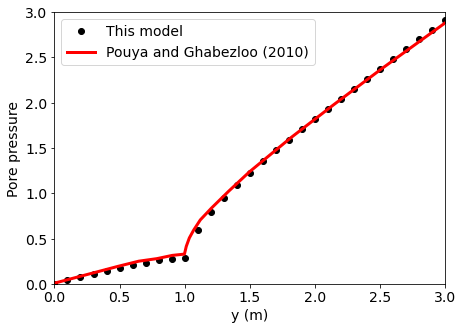

In [12]:
fig = plt.figure(figsize=[7.,5])

plt.subplot(111)
plt.plot(y_TFVM,p_TFVM,'ko',label='This model')

y_anal = np.linspace(-Ly/2,Ly/2,1000)
#plt.plot(y_anal, analytic2D(ell, 0, y_anal) ,'r-',linewidth=3,label='Analytic')
plt.plot(df['X'],df['Y'],'r-',linewidth=3,label='Pouya and Ghabezloo (2010)')

plt.xlabel('y (m)')
plt.ylabel('Pore pressure')
plt.xlim(0,3)
plt.ylim(0,3)
plt.legend()
plt.show()

In [13]:
# Geometry
dx = Lx/(nx-1)
dy = Ly/(ny-1)
xb, yb = np.mgrid[-(Lx/2.+dx/2):(Lx/2.+dx/2):(nx+1)*1j, -(Ly/2.+dy/2):(Ly/2.+dy/2):(ny+1)*1j] # this is coordinates of cell boundaries


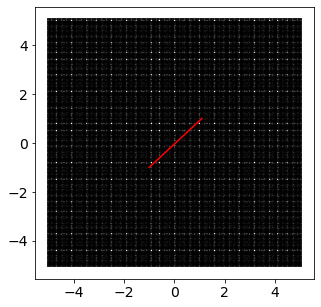

In [14]:
plt.figure(figsize=(Lx/2,Ly/2))

plt.plot(xb,yb, 'k')
plt.plot(xb.T,yb.T, 'k')
plt.plot(x,y, 'k--')
plt.plot(x.T,y.T, 'k--')

# Fracture
tip1 = [-1,-1]
tip2 = [1.1,1]
plt.plot([tip1[0], tip2[0]], [tip1[1], tip2[1]], 'r')

plt.show()

In [15]:
fracture_1 = generate_fracture(x,y,nx,ny, tip1, tip2)
print(fracture_1)

[[40, 40], [41, 41], [42, 42], [43, 42], [43, 43], [44, 43], [44, 44], [45, 44], [45, 45], [46, 45], [46, 46], [47, 46], [47, 47], [48, 47], [48, 48], [49, 48], [49, 49], [50, 49], [50, 50], [51, 50], [51, 51], [52, 51], [52, 52], [53, 52], [53, 53], [54, 53], [54, 54], [55, 54], [55, 55], [56, 55], [56, 56], [57, 56], [57, 57], [58, 57], [58, 58], [59, 58], [60, 59], [61, 60]]
